In [0]:
!pip install -q torch==1.0.1
import torch

     |████████████████████████████████| 560.1MB 29kB/s 
ERROR: torchvision 0.4.1+cu100 has requirement torch==1.3.0, but you'll have torch 1.0.1 which is incompatible.


In [0]:
print(torch.__version__)

1.0.1


In [0]:
!pip install ekphrasis

     |████████████████████████████████| 81kB 9.9MB/s 
     |████████████████████████████████| 194kB 41.7MB/s 
     |████████████████████████████████| 61kB 9.6MB/s 
  Created wheel for ekphrasis: filename=ekphrasis-0.5.1-cp36-none-any.whl size=82844 sha256=9818e3c885962e2d00e6d43c81bb5a51c40fb859be137e5c789ed0b9571b68f2
  Stored in directory: /root/.cache/pip/wheels/2f/c5/9b/c9b60f535a2cf9fdbc92d84c4801a010c35a9cd348011ed2a1
  Created wheel for ujson: filename=ujson-1.35-cp36-cp36m-linux_x86_64.whl size=68027 sha256=ab58bb34df7595eebbfe97a25574726d8fffb03d69ae56774baa8513b4472028
  Stored in directory: /root/.cache/pip/wheels/28/77/e4/0311145b9c2e2f01470e744855131f9e34d6919687550f87d1
  Created wheel for ftfy: filename=ftfy-5.6-cp36-none-any.whl size=44553 sha256=26f2314fe94e85d902a6114f29a2b61b13dc48be1905d5264651395487abe212
  Stored in directory: /root/.cache/pip/wheels/43/34/ce/cbb38d71543c408de56f3c5e26ce8ba495a0fa5a28eaaf1046
Successfully built ekphrasis ujson ftfy


In [0]:
!pip install emoji --upgrade

Requirement already up-to-date: emoji in /usr/local/lib/python3.6/dist-packages (0.5.4)


In [0]:
%tensorflow_version 1.x

In [0]:
import os
import json
import emoji
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.decomposition import PCA

In [0]:
from __future__ import print_function, division, unicode_literals
%cd contextual_emotion_detection/torchMoji/
from torchmoji.sentence_tokenizer import SentenceTokenizer
from torchmoji.model_def import torchmoji_feature_encoding
from torchmoji.model_def import torchmoji_emojis
from torchmoji.global_variables import PRETRAINED_PATH, VOCAB_PATH
%cd ../..

In [0]:
training_data = pd.read_csv('contextual_emotion_detection/data/train.txt', sep = '\t')

In [0]:
test_data = pd.read_csv('contextual_emotion_detection/data/test.txt', sep = '\t')

In [0]:
label_to_emotion = {0: "others", 1: "happy", 2: "sad", 3: "angry"}
emotion_to_label = {"others": 0, "happy": 1, "sad": 2, "angry": 3}

In [0]:
additional_emoticons = {
    '(^・^)': '<happy>', ':‑c': '<sad>', '=‑d': '<happy>', ":'‑)": '<happy>', ':‑d': '<laugh>',
    ':‑(': '<sad>', ';‑)': '<happy>', ':‑)': '<happy>', ':\\/': '<sad>', 'd=<': '<annoyed>',
    ':‑/': '<annoyed>', ';‑]': '<happy>', '(^�^)': '<happy>', 'angru': 'angry', "d‑':":
        '<annoyed>', ":'‑(": '<sad>', ":‑[": '<annoyed>', '(�?�)': '<happy>', 'x‑d': '<laugh>',
}

### Pre-processing conversation text

In [0]:
text_pre_processor = TextPreProcessor(
    normalize = ['url', 'email', 'percent', 'money', 'phone', 'user',
               'time', 'url', 'date', 'number'],
    annotate = {"hashtag", "allcaps", "elongated", "repeated",
              'emphasis', 'censored'},
    fix_html = True,
    segmenter = "twitter",
    corrector = "twitter", # spell correction
    unpack_hashtags = True,
    unpack_contractions = True, # expand word abbreviations
    spell_correct_elong = True,
    tokenizer = SocialTokenizer(lowercase = True).tokenize,
    dicts = [emoticons, additional_emoticons]
)

def pre_process(conversation_text):
    conversation_text = " ".join(text_pre_processor.pre_process_doc(conversation_text))
    return conversation_text

Reading twitter - 1grams ...
Reading twitter - 2grams ...
Reading twitter - 1grams ...


##### Training data

In [0]:
# Pre-process and append the conversations to their respective sets
conversation1 = []
conversation2 = []
conversation3 = []
label = []
category_index = {}
current_index = 0

for index, record in training_data.iterrows():
    if record['label'] not in category_index:
        category_index[record['label']] = current_index
        current_index += 1
    label.append(category_index[record['label']])
    conversation1.append(pre_process(record['turn1']))
    conversation2.append(pre_process(record['turn2']))
    conversation3.append(pre_process(record['turn3']))

##### Testing data

In [0]:
# Pre-process and append the conversations to their respective sets
test_conversation1 = []
test_conversation2 = []
test_conversation3 = []
test_label = []
test_category_index = {}
current_index = 0

for index, record in test_data.iterrows():
    if record['label'] not in test_category_index:
        test_category_index[record['label']] = current_index
        current_index += 1
    test_label.append(test_category_index[record['label']])
    test_conversation1.append(pre_process(record['turn1']))
    test_conversation2.append(pre_process(record['turn2']))
    test_conversation3.append(pre_process(record['turn3']))

### Encoding conversations to fixed sized vector encodings

In [0]:
# Use the pre-trained model provided by torcMoji
# which is a PyTorch implementation of DeepMoji
def encode_emoji(conversation_text):
    model = torchmoji_emojis(PRETRAINED_PATH)
    vector_size = 30
    batch_size = 32
    print("Tokenizing conversation text")
    with open(VOCAB_PATH, 'r') as f:
        vocabulary = json.load(f)
    tokenizer = SentenceTokenizer(vocabulary, vector_size)
    tokenized_conversation, _, _ = tokenizer.tokenize_sentences(conversation_text)
    print("Make predictions using Pretrained model: ", model)    
    conversation_encoding = np.zeros((len(conversation_text), 64))
    for index in range(0, len(conversation_text), 300):    
        conversation_encoding[index : index + 300] = model(tokenized_conversation[index : index + 300])
    return conversation_encoding

##### Encode training data

In [0]:
label = np.array(label)
index_of_other_records = np.where(label == 0)[0]
conversation1 = np.array(conversation1)
conversation2 = np.array(conversation2)
conversation3 = np.array(conversation3)

In [0]:
conversation_all = np.c_[conversation1, conversation2, conversation3]
conversation_all = np.array([' <eos> \n '.join(conversation) for conversation in conversation_all])

In [0]:
encoded_conversations = encode_emoji(conversation_all)

/content/contextual_emotion_detection/torchMoji/torchmoji/model_def.py:159: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  nn.init.uniform(self.embed.weight.data, a=-0.5, b=0.5)
/content/contextual_emotion_detection/torchMoji/torchmoji/model_def.py:161: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(t)
/content/contextual_emotion_detection/torchMoji/torchmoji/model_def.py:163: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  nn.init.orthogonal(t)
/content/contextual_emotion_detection/torchMoji/torchmoji/model_def.py:165: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(t, 0)
/content/contextual_emotion_detection/torchMoji/torchmoji/model_def.py:167: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(self.output_layer[0].weight.data)


Tokenizing conversation text
Make predictions using Pretrained model:  TorchMoji(
  (embed): Embedding(50000, 256)
  (embed_dropout): Dropout2d(p=0)
  (lstm_0): LSTMHardSigmoid(256, 512, batch_first=True, bidirectional=True)
  (lstm_1): LSTMHardSigmoid(1024, 512, batch_first=True, bidirectional=True)
  (attention_layer): Attention(2304, return attention=False)
  (final_dropout): Dropout(p=0)
  (output_layer): Sequential(
    (0): Linear(in_features=2304, out_features=64, bias=True)
    (1): Softmax()
  )
)


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [0]:
encoded_conversations.shape

(30160, 64)

In [0]:
pickle.dump(encoded_conversations, open("contextual_emotion_detection/deepmoji/data/encoded_conversations.bin", "wb"))

### K-means clustering

In [0]:
def plot_clusters(data, labels, centroids = None, x1 = 0, x2 = 1):
  cluster_colors = {
      0:'#2AD2D6', # Aqua
      1:'#DF4F40', # Peach
      2:'#6B9FE8', # Blue
      3:'#922CD1', # Purple
      4:'#D24962', # Pink
      5:'#E46F3F', # Orange
      6:'#F6CC55', # Yellow
      7:'#39231B', # Coffee-Brown
      8:'#4CB97A'  # Green
      }
  color_palette = [cluster_colors[index % len(cluster_colors)] for index in labels]
  plt.figure(figsize = (12,8))
  plt.grid(False)
  plt.scatter(data[:, x1], data[:, x2], c = color_palette, alpha = 0.75)
  if centroids is not None:
    plt.scatter(centroids[:, 0], centroids[:, 1],marker = '*', c = '#292F4C')
    plt.show()

In [0]:
encoded_conversations_others = encoded_conversations[np.where(training_data['label'] == 'others')[0]]

In [0]:
encoded_conversations_others.shape

(14948, 64)

##### Explore cluster sizes

In [0]:
# Kmeans inertia: Sum of squared distances of samples to their closest cluster center
# The closer the points are in clusters (tight clusters), the better the quality of the clustering
kmeans = []
kmeans_inertia = []
# Explore different values for number of clusters ie k
for k in range(2, 50, 2):
    print("Number of clusters: ", k)
    kmeans.append(KMeans(n_clusters = k, init = 'k-means++', n_init = 50, max_iter = 1500, random_state = 0).fit(encoded_conversations_others))
    kmeans_inertia.append(kmeans[-1].inertia_)
    print(kmeans[-1].inertia_)

Number of clusters:  2
210.43913161398433
Number of clusters:  4
131.54645369916926
Number of clusters:  6
106.45074246890098
Number of clusters:  8
93.16603728328079
Number of clusters:  10
83.77541391787261
Number of clusters:  12
78.0831858772733
Number of clusters:  14
73.81064067066804
Number of clusters:  16
70.15147553133822
Number of clusters:  18
67.4278842751102
Number of clusters:  20
65.06785134156512
Number of clusters:  22
63.00422443829687
Number of clusters:  24
61.18364412445587
Number of clusters:  26
59.66061216054695
Number of clusters:  28
58.3771479131157
Number of clusters:  30
57.060967939700966
Number of clusters:  32
55.91975213442787
Number of clusters:  34
54.92100409033631
Number of clusters:  36
53.969472174373664
Number of clusters:  38
52.99311237986761
Number of clusters:  40
52.297004637944696
Number of clusters:  42
51.51263542661968
Number of clusters:  44
50.83979043245674
Number of clusters:  46
50.16666392101685
Number of clusters:  48
49.50893250

##### Elbow method to find optimal cluster size

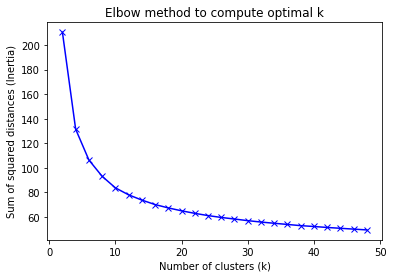

In [0]:
# Plot the graph of inertia vs number of clusters (k)
# to find out the optimal number of clusters
# The method is called elbow method
# The optimal number of clusters is the tip of the graph elbow bend
plt.plot(range(2, (len(kmeans_inertia) + 1) * 2, 2), kmeans_inertia, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of squared distances (Inertia)')
plt.title('Elbow method to compute optimal k')
plt.show()

##### Dimensionality Reduction for cluster visualization

In [0]:
# Reduce cluseter dimensions for 2D visualization
# explained_variance_ratio_: Percentage of variance explained by each of the selected components
# When we reduce the dimensionality, some of the variance/information is lost
# explained_variance_ratio_ will tell us how much of that information is preserved
dimension = 2
pca = PCA(n_components = dimension)
encoded_conversations_others_reduced = pca.fit_transform(encoded_conversations_others)
print("Percentage of variance preserved in each dimension: ", pca.explained_variance_ratio_)

Percentage of variance preserved in each dimension:  [0.41537301 0.38233798]


##### Cluster Plots

5 clusters


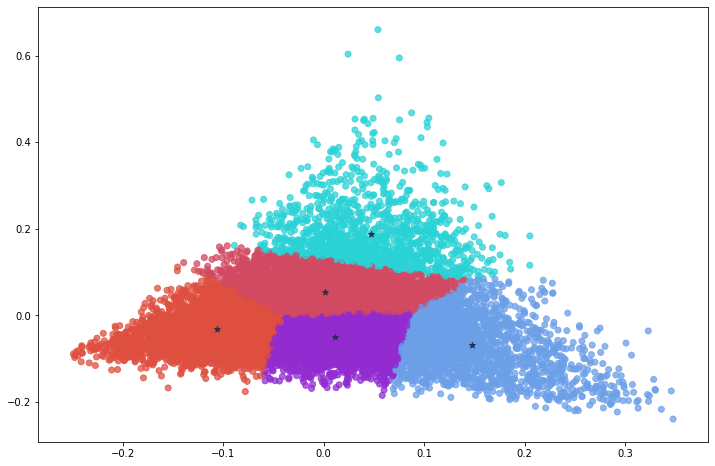

6 clusters


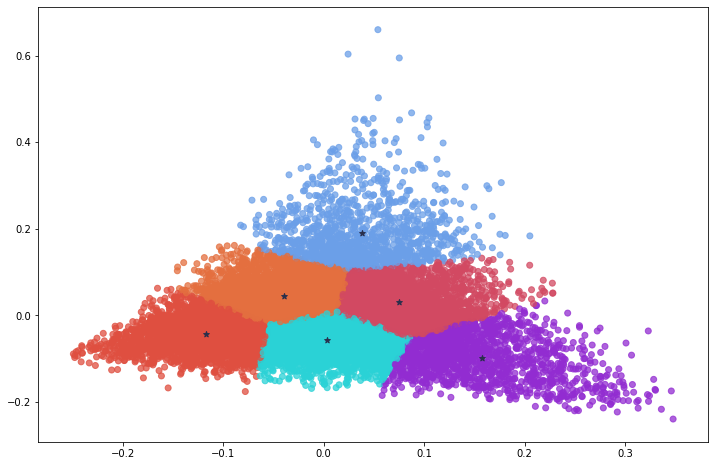

7 clusters


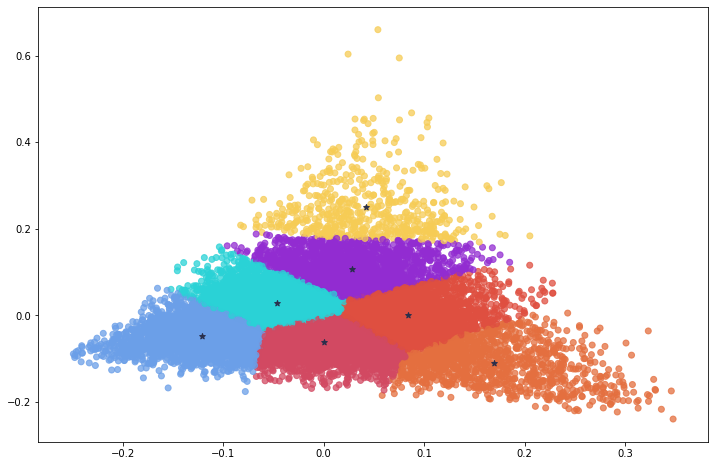

8 clusters


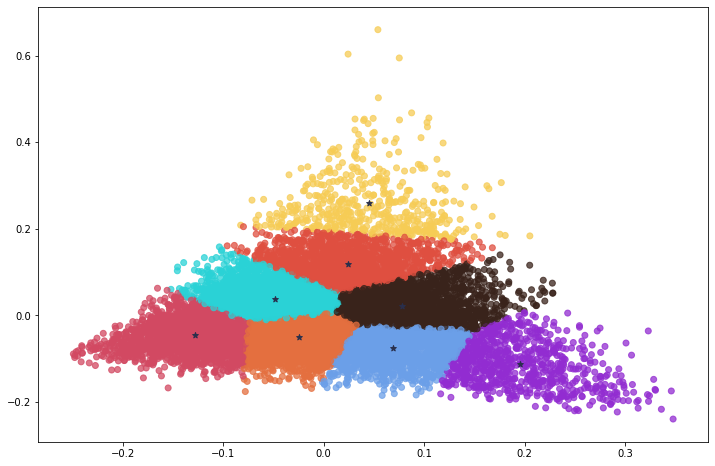

In [0]:
# Cluster Visualization
for k in [5, 6, 7, 8]:
    kmeans_reduced = KMeans(n_clusters = k, init = 'k-means++', n_init = 50, max_iter = 1500, random_state = 0).fit(encoded_conversations_others_reduced)
    print("%s clusters" % k)
    plot_clusters(encoded_conversations_others_reduced, kmeans_reduced.predict(encoded_conversations_others_reduced), kmeans_reduced.cluster_centers_)

In [0]:
conversation1_emoji = encode_emoji(conversation1)
conversation2_emoji = encode_emoji(conversation2)
conversation3_emoji = encode_emoji(conversation3)

/content/contextual_emotion_detection/torchMoji/torchmoji/model_def.py:159: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  nn.init.uniform(self.embed.weight.data, a=-0.5, b=0.5)
/content/contextual_emotion_detection/torchMoji/torchmoji/model_def.py:161: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(t)
/content/contextual_emotion_detection/torchMoji/torchmoji/model_def.py:163: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  nn.init.orthogonal(t)
/content/contextual_emotion_detection/torchMoji/torchmoji/model_def.py:165: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(t, 0)
/content/contextual_emotion_detection/torchMoji/torchmoji/model_def.py:167: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(self.output_layer[0].weight.data)


Tokenizing conversation text
Make predictions using Pretrained model:  TorchMoji(
  (embed): Embedding(50000, 256)
  (embed_dropout): Dropout2d(p=0)
  (lstm_0): LSTMHardSigmoid(256, 512, batch_first=True, bidirectional=True)
  (lstm_1): LSTMHardSigmoid(1024, 512, batch_first=True, bidirectional=True)
  (attention_layer): Attention(2304, return attention=False)
  (final_dropout): Dropout(p=0)
  (output_layer): Sequential(
    (0): Linear(in_features=2304, out_features=64, bias=True)
    (1): Softmax()
  )
)


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Tokenizing conversation text
Make predictions using Pretrained model:  TorchMoji(
  (embed): Embedding(50000, 256)
  (embed_dropout): Dropout2d(p=0)
  (lstm_0): LSTMHardSigmoid(256, 512, batch_first=True, bidirectional=True)
  (lstm_1): LSTMHardSigmoid(1024, 512, batch_first=True, bidirectional=True)
  (attention_layer): Attention(2304, return attention=False)
  (final_dropout): Dropout(p=0)
  (output_layer): Sequential(
    (0): Linear(in_features=2304, out_features=64, bias=True)
    (1): Softmax()
  )
)
Tokenizing conversation text
Make predictions using Pretrained model:  TorchMoji(
  (embed): Embedding(50000, 256)
  (embed_dropout): Dropout2d(p=0)
  (lstm_0): LSTMHardSigmoid(256, 512, batch_first=True, bidirectional=True)
  (lstm_1): LSTMHardSigmoid(1024, 512, batch_first=True, bidirectional=True)
  (attention_layer): Attention(2304, return attention=False)
  (final_dropout): Dropout(p=0)
  (output_layer): Sequential(
    (0): Linear(in_features=2304, out_features=64, bias=True)
 

In [0]:
def top_emojis(emojis, k):
    index = np.argpartition(emojis, -k)[-k : ]
    return index[np.argsort(emojis[index])][ : : -1]

In [0]:
emoji_list = ":joy: :unamused: :weary: :sob: :heart_eyes: \
:pensive: :ok_hand: :blush: :heart: :smirk: \
:grin: :notes: :flushed: :100: :sleeping: \
:relieved: :relaxed: :raised_hands: :two_hearts: :expressionless: \
:sweat_smile: :pray: :confused: :kissing_heart: :heartbeat: \
:neutral_face: :information_desk_person: :disappointed: :see_no_evil: :tired_face: \
:v: :sunglasses: :rage: :thumbsup: :cry: \
:sleepy: :yum: :triumph: :hand: :mask: \
:clap: :eyes: :gun: :persevere: :smiling_imp: \
:sweat: :broken_heart: :yellow_heart: :musical_note: :speak_no_evil: \
:wink: :skull: :confounded: :smile: :stuck_out_tongue_winking_eye: \
:angry: :no_good: :muscle: :facepunch: :purple_heart: \
:sparkling_heart: :blue_heart: :grimacing: :sparkles:".split(' ')

In [0]:
emojis1 = []
emojis2 = []
emojis3 = []

for index, conversation_text in enumerate(training_data['turn1'].values):
    emoji_ids = top_emojis(conversation1_emoji[index], 5)
    emojis = map(lambda x: emoji_list[x], emoji_ids)
    emojis1.append(emoji.emojize("{} {}".format(conversation_text,' '.join(emojis)), use_aliases = True))

for index, conversation_text in enumerate(training_data['turn2'].values):
    emoji_ids = top_emojis(conversation2_emoji[index], 5)
    emojis = map(lambda x: emoji_list[x], emoji_ids)
    emojis2.append(emoji.emojize("{} {}".format(conversation_text,' '.join(emojis)), use_aliases=True))

for index, conversation_text in enumerate(training_data['turn3'].values):
    emoji_ids = top_emojis(conversation3_emoji[index], 5)
    emojis = map(lambda x: emoji_list[x], emoji_ids)
    emojis3.append(emoji.emojize("{} {}".format(conversation_text,' '.join(emojis)), use_aliases=True))

training_data['emojis1'] = emojis1
training_data['emojis2'] = emojis2
training_data['emojis3'] = emojis3

In [0]:
emoji_labels = []
for index, encoded_conversation in enumerate(encoded_conversations):
    emoji_ids = top_emojis(encoded_conversation, 5)
    emojis = map(lambda x: emoji_list[x], emoji_ids)
    emoji_labels.append(emoji.emojize(' '.join(emojis), use_aliases = True))   
training_data['emoji_labels'] = emoji_labels

In [0]:
training_data

,id,turn1,turn2,turn3,label,emojis1,emojis2,emojis3,emoji_labels
0,0,Don't worry I'm girl,hmm how do I know if you are,What's ur name?,others,Don't worry I'm girl 💁 ✋ 🙅 😉 👊,hmm how do I know if you are 👀 😏 😕 😐 🙊,What's ur name? 👀 😳 😏 😂 😕,☺ 💓 🎶 💛 🎵
1,1,When did I?,saw many times i think -_-,No. I never saw you,angry,When did I? 😳 👀 😕 😐 😔,saw many times i think -_- 👀 😳 😬 😕 🙈,No. I never saw you 😳 💔 😔 😐 😕,💓 ☺ 🎶 💛 😢
2,2,By,by Google Chrome,Where you live,others,By ✌ 🎵 💔 💜 💓,by Google Chrome 👍 👌 🎵 😍 🔫,Where you live 👀 🎵 😈 😕 😩,💓 🎶 🎵 💛 ✨
3,3,U r ridiculous,I might be ridiculous but I am telling the truth.,U little disgusting whore,angry,U r ridiculous 😡 😠 😤 ✋ 😑,I might be ridiculous but I am telling the tru...,U little disgusting whore 😷 😡 😠 😖 👊,💓 💛 ☺ ✨ ✌
4,4,Just for time pass,wt do u do 4 a living then,Maybe,others,Just for time pass 🙏 😌 😏 😈 😅,wt do u do 4 a living then ☺ ✌ 🎵 🎶 💔,Maybe 😏 🎵 🙊 😌 😕,☺ 💓 💛 ✨ 🎵
...,...,...,...,...,...,...,...,...,...
30155,30155,I don't work,I could take your shift,I am a student,others,I don't work 🙅 ✋ 😑 😤 😒,I could take your shift 😏 🎵 😈 😉 🎶,I am a student 💁 😎 😈 💪 😏,🎶 🎵 ☺ ✨ 💓
30156,30156,I'm not getting you 😭😭😭,Why are you crying??,Because you are not making any sense,sad,I'm not getting you 😭😭😭 🙅 😡 ✋ 😠 😤,Why are you crying?? ☺ 💔 💛 💓 😢,Because you are not making any sense 😑 🙅 😒 ✋ 😠,💔 😠 💓 😡 😢
30157,30157,Haha,"no, seriously. What is up with that o-o",Had your breakfast?,others,Haha 😄 😅 😈 😏 😂,"no, seriously. What is up with that o-o ✋ 🙅 😷 😠 😡",Had your breakfast? 👀 😋 😏 🙊 😌,☺ 💓 😄 💛 😜
30158,30158,Do you sing?,yea a lil,Nice,others,Do you sing? 🎶 🎵 👀 😏 😍,yea a lil 😏 👀 😴 🙊 😅,Nice 👍 👏 👌 😎 😏,💓 💛 ☺ 🎶 🎵


In [0]:
data_others = training_data[training_data['label'] == 'others']

In [0]:
len(data_others)

14948

In [0]:
def cluster_conversation_emojis(data_others, k, complete = False):
    encoded_conversations = encoded_conversations_others if complete else encoded_conversations_others_reduced
    kmeans = KMeans(n_clusters = k, init = 'k-means++', n_init = 50, max_iter = 1500, random_state = 0).fit(encoded_conversations)
    data_others['cluster'] = kmeans.predict(encoded_conversations)
    grouped_by_cluster = data_others.groupby(by = 'cluster')
    aggregate = grouped_by_cluster.agg({'label':'count','emoji_labels':''.join})
    aggregate['emoji_labels'] = aggregate['emoji_labels'].apply(set)
    aggregate['count'] = aggregate['emoji_labels'].apply(len)
    unique_emojis_list = []
    emoji_sets = aggregate['emoji_labels'].values
    emoji_mean = []
    unique=[]

    for index in range(len(emoji_sets)):
        unique_emojis_list.append({'total':len(emoji_sets[index])})
        cluster_center = kmeans.cluster_centers_[index] if complete else pca.inverse_transform(kmeans.cluster_centers_[index])
        emoji_ids = top_emojis(cluster_center, 30)
        emojis = map(lambda x: emoji_list[x], emoji_ids[10 : ])
        emoji_mean.append(emoji.emojize(' '.join(emojis), use_aliases = True))
        unique_emojis = set(emoji_sets[index])
        for emo in range(0,len(emoji_sets)):
            unique_emojis_list[index][emo] = (str(len(emoji_sets[index] - emoji_sets[emo])) + ' : ') + ''.join(emoji_sets[index]-emoji_sets[emo])
            unique_emojis = unique_emojis.intersection(emoji_sets[index] - emoji_sets[emo]) if index != emoji else unique_emojis
        unique.append(unique_emojis)

    aggregate['unique'] = unique
    aggregate['mean_emoji'] = emoji_mean
    return aggregate[['unique','mean_emoji','count','label']], pd.DataFrame(unique_emojis_list), grouped_by_cluster

In [0]:
aggregate, unique_emojis_list, _ = cluster_conversation_emojis(data_others, 5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [0]:
aggregate

,unique,mean_emoji,count,label
cluster,,,,
0,{},😜 ❤ 👀 😁 🎶 😎 🎵 ✋ 😌 💯 😬 👌 👊 👏 😢 🙌 💔 😘 💪 😋,32,1243
1,{},😄 🙏 💯 💔 😜 ✋ 😎 😊 👊 ❤ 🔫 😢 😕 👌 😬 😁 👏 😌 😠 💀,57,3832
2,{},👍 😄 💜 😘 💯 😊 💖 💕 💙 👌 👀 💔 😜 👏 ✋ 🙌 👊 😎 😁 😍,36,2004
3,{},🙏 👀 😄 💯 😊 💔 😜 ✋ 😎 👊 👌 👏 😁 💜 🔫 😢 😌 🙌 😬 💪,46,3850
4,{},🙏 👀 ❤ 😊 😜 💯 😎 ✋ 💔 😁 👊 👌 😌 😬 👏 😢 🔫 🙌 💪 💀,43,4019


In [0]:
unique_emojis_list

,total,0,1,2,3,4
0,32,0 :,1 : 😁,3 : 😕😁😡,2 : 😁😡,2 : 😁😡
1,57,26 : 💖😐😒😞💙😓🙊😷😈😅👌😳😑😬💁🙅😣💕😌👏💜💀😤😖🙌🙈,0 :,22 : 😐😒😞😡😓🙊😷😈😅😕😳😑😬💁🙅😣💕😌😤😖🙌🙈,12 : 😬😓😐😑🙈😤😅😌😒😳😞😡,14 : 😬💁💖💜😑😷💕😈😤😖😒😳😞😡
2,36,7 : 💜💖💀😍👌👏💙,1 : 😍,0 :,1 : 😍,3 : 😍💜💖
3,46,16 : 💁💖💜🙊🙅😣💀😷💕😈😖😭🙌👌👏💙,1 : 😭,11 : 💁🙊🙅😣😷💕😈😖😭🙌😕,0 :,8 : 💁💖💜😷💕😈😖😭
4,43,13 : 😌😓💀🙊🙅😣😐🙈😅🙌👌👏💙,0 :,10 : 😓🙊🙅😣😐😅🙌😌😕🙈,5 : 😌😓😐😅🙈,0 :


In [0]:
aggregate, unique_emojis_list, _ = cluster_conversation_emojis(data_others, 5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [0]:
aggregate

,unique,mean_emoji,count,label
cluster,,,,
0,{},😜 ❤ 👀 😁 🎶 😎 🎵 ✋ 😌 💯 😬 👌 👊 👏 😢 🙌 💔 😘 💪 😋,32,1243
1,{},😄 🙏 💯 💔 😜 ✋ 😎 😊 👊 ❤ 🔫 😢 😕 👌 😬 😁 👏 😌 😠 💀,57,3832
2,{},👍 😄 💜 😘 💯 😊 💖 💕 💙 👌 👀 💔 😜 👏 ✋ 🙌 👊 😎 😁 😍,36,2004
3,{},🙏 👀 😄 💯 😊 💔 😜 ✋ 😎 👊 👌 👏 😁 💜 🔫 😢 😌 🙌 😬 💪,46,3850
4,{},🙏 👀 ❤ 😊 😜 💯 😎 ✋ 💔 😁 👊 👌 😌 😬 👏 😢 🔫 🙌 💪 💀,43,4019


In [0]:
unique_emojis_list

,total,0,1,2,3,4
0,32,0 :,1 : 😁,3 : 😕😁😡,2 : 😁😡,2 : 😁😡
1,57,26 : 💖😐😒😞💙😓🙊😷😈😅👌😳😑😬💁🙅😣💕😌👏💜💀😤😖🙌🙈,0 :,22 : 😐😒😞😡😓🙊😷😈😅😕😳😑😬💁🙅😣💕😌😤😖🙌🙈,12 : 😬😓😐😑🙈😤😅😌😒😳😞😡,14 : 😬💁💖💜😑😷💕😈😤😖😒😳😞😡
2,36,7 : 💜💖💀😍👌👏💙,1 : 😍,0 :,1 : 😍,3 : 😍💜💖
3,46,16 : 💁💖💜🙊🙅😣💀😷💕😈😖😭🙌👌👏💙,1 : 😭,11 : 💁🙊🙅😣😷💕😈😖😭🙌😕,0 :,8 : 💁💖💜😷💕😈😖😭
4,43,13 : 😌😓💀🙊🙅😣😐🙈😅🙌👌👏💙,0 :,10 : 😓🙊🙅😣😐😅🙌😌😕🙈,5 : 😌😓😐😅🙈,0 :


In [0]:
aggregate, unique_emojis_list, clusters = cluster_conversation_emojis(data_others, 10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [0]:
aggregate

,unique,mean_emoji,count,label
cluster,,,,
0,{},👀 😊 🙏 😜 😎 💯 ✋ ❤ 😁 💔 😌 👊 😬 😢 👌 👏 😕 🔫 💀 💪,41,1369
1,{},🙏 😄 👀 💯 💔 😊 💜 😜 👌 ✋ 👊 😎 😘 👏 💖 💕 💙 😁 🙌 💪,37,1505
2,{},❤ 😄 🙏 💯 💔 😜 ✋ 😊 😎 👊 👌 🔫 👏 😢 😁 😬 😌 💀 💪 💜,47,2260
3,{},🎶 😊 🎵 😜 👀 💯 😁 😎 ✋ 😌 👌 👊 👏 😘 😬 💔 🙌 💜 😢 💪,30,1139
4,{},😜 😁 👀 😎 😌 ✋ 😬 💯 ❤ 😢 👏 👊 👌 🙌 😅 😕 😋 💪 🙊 😪,27,496
5,{},💜 👍 😘 💖 💕 💙 💯 😄 👌 😊 🙌 👏 😍 💔 👊 ✋ 💪 😁 😜 😎,24,669
6,{},❤ 🙏 👀 😊 💯 😜 ✋ 😎 💔 👊 👌 😁 👏 😌 😢 😬 🔫 💜 🙌 💪,37,2438
7,{},🙏 😄 😊 💯 💜 😘 👀 😜 👌 ✋ 😁 😎 💖 💔 💕 👏 💙 👊 🙌 😌,30,1264
8,{},😄 🙏 😜 😊 💯 💔 ✋ 😎 ❤ 👊 🔫 😢 😁 😬 👌 😕 😌 👏 💀 😠,44,2146


In [0]:
unique_emojis_list

,total,0,1,2,3,4,5,6,7,8,9
0,41,0 :,12 : 😠😓😪😣😐😁😅🙌😌😕🙈😎,5 : 😌😐😁😅🙈,12 : 😓💀🙅😣😐😁😅🙌😌😕👏🙈,14 : 😓💀😪🙅😐🔫😣😘😅🙌😌👏🙈😎,21 : 😋😐😠😓🔫✋😁😅😕😜🙅😣😌😄😎💀👊🙌🙈😊💪,7 : 😓😐😘😁😅😌🙈,12 : 😓💀🙅😣😐😁😅🙌😌😕🙈💪,4 : 😘😁🙌🙈,2 : 😁😌
1,37,8 : 💁💖💜😷💕😭👌💙,0 :,2 : 💕😭,11 : 💁💖💜💀🙅😷💕😭👌👏💙,13 : 💁💖💜💀🙅🔫😷😘💕😭👌👏💙,15 : 😋💁💖💀🙅🔫😷✋👊💕😊😭😄💪😜,7 : 💁💖💜😷😘💕😭,11 : 💁💖💜💀🙅😷💕😭👌💙💪,6 : 💜💖😘💕😭💙,1 : 😭
2,47,11 : 💁💖💜🙊💙😷😈😖👌😞😡,12 : 😠😓🙊😪😣😈😖🙌😕😞😡😎,0 :,17 : 💁😓💖🙊🙅😣💜💀😷😈😖👏🙌👌😕😞💙,21 : 💖😘😞💙😡😓🙊😪🔫😷😈👌💁🙅😣👏😎💜💀😖🙌,24 : 😋💖😞😡😠😓🙊🔫✋😷😈😕😜💁🙅😣😄😎💀👊😖🙌😊💪,10 : 💁😓💖💜😷😘😈😖😞😡,18 : 💁😓💖🙊🙅😣💙💜😷💀😈😖🙌👌😕😞😡💪,6 : 💜💖😘😈🙌💙,0 :
3,30,1 : 😡,4 : 😎😪😡😠,0 :,0 :,5 : 😪🔫😘😡😎,11 : 💪😋😠🔫✋👊😊😄😡😎😜,2 : 😘😡,2 : 😡💪,1 : 😘,0 :
4,27,0 :,3 : 😕😁😠,1 : 😁,2 : 😕😁,0 :,10 : 😋😠👊✋😊😁😕😄💪😜,1 : 😁,3 : 😕😁💪,1 : 😁,1 : 😁
5,24,4 : 💙👌💜😍,2 : 😪😍,1 : 😍,5 : 💜😍👌👏💙,7 : 💜😪😍😘👌👏💙,0 :,3 : 😘💜😍,3 : 💙💜👌,4 : 😘💙💜😍,1 : 😍
6,37,3 : 🙊💙👌,7 : 😠🙊😪😣🙌😕😎,0 :,9 : 💀🙊🙅😣🙌👌😕👏💙,11 : 💀🙊😪🙅😣🔫🙌👌👏💙😎,16 : 💪😋😠💀🙊🙅😣🔫✋👊😊🙌😕😄😎😜,0 :,9 : 💀🙊🙅😣🙌👌😕💙💪,2 : 💙🙌,0 :
7,30,1 : 😍,4 : 😪😎😠😍,1 : 😍,2 : 👏😍,6 : 😪🔫😍😘👏😎,9 : 😋😠🔫✋👊😊😄😎😜,2 : 😘😍,0 :,2 : 😘😍,1 : 😍
8,44,7 : 💁🙊😷😖👌😞😡,13 : 😠😓🙊😪😣😐😖😅😌😕😞😡😎,3 : 😐😅😌,15 : 💁😓😌🙊🙅😣😐💀😷😖😅👏👌😕😞,18 : 💁😓😌🙊😪🙅😐🔫😷😣💀😖😅👏👌😞😡😎,24 : 😋😐😞😡😠😓🙊🔫✋😷😅😕😜💁🙅😣😌😄😎💀👊😖😊💪,9 : 💁😓😐😷😖😅😌😞😡,16 : 💁😓😌🙊🙅😣😐💀😷😖😅👌😕😞😡💪,0 :,1 : 😌
9,56,17 : 😬💁💖💜🙊💙😑😷💕😈😤😖👌😒😳😞😡,20 : 😠😬😓🙊😪😣😐😑😤😈😖😅🙌🙈😒😳😞😡😎😕,9 : 😬😐💕😤😅🙈😒😳😑,26 : 💖😐😒😞💙😓🙊😷😈😅👌😕😳😑😬💁🙅😣💕👏💜💀😤😖🙌🙈,30 : 💖😐😘😒😞😡💙😓🙊😪🔫😷😈😅👌😳😑😬💁🙅😣💕👏😎💜💀😤😖🙌🙈,33 : 😋💖😐😒😞😡😠😓🙊🔫😷✋😈😅😕😳😑😜😬💁🙅😣💕😄😎💀👊😤😖🙌🙈😊💪,19 : 😬💁💖😓💜😐😑😷😘💕😈😤😖😅🙈😒😳😞😡,27 : 💖😐😒😞💙😡😓🙊😷😈😅👌😕😳😑😬💁🙅😣💕💜💀😤😖🙌🙈💪,13 : 😬💜💖😘💕😈😤🙌🙈😒😳😑💙,0 :


In [0]:
preview = clusters.apply(lambda row: row.sample(5))
for index in range(len(aggregate.unique.values)):
    preview['label'][index] = aggregate['unique'][index]
preview

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


id  ... cluster
cluster               ...        
0       21983  21983  ...       0
        4695    4695  ...       0
        25673  25673  ...       0
        22471  22471  ...       0
        8950    8950  ...       0
1       5095    5095  ...       1
        26361  26361  ...       1
        21515  21515  ...       1
        25494  25494  ...       1
        21567  21567  ...       1
2       216      216  ...       2
        891      891  ...       2
        1185    1185  ...       2
        29281  29281  ...       2
        7489    7489  ...       2
3       534      534  ...       3
        22911  22911  ...       3
        3543    3543  ...       3
        8957    8957  ...       3
        24046  24046  ...       3
4       5629    5629  ...       4
        10254  10254  ...       4
        9252    9252  ...       4
        4312    4312  ...       4
        17409  17409  ...       4
5       13972  13972  ...       5
        27348  27348  ...       5
        4343    4343  ...       5
        13507  13507  ...       5
        26669  26669  ...       5
6       15105  15105  ...       6
        7221    7221  ...       6
        22896  22896  ...       6
        24759  24759  ...       6
        13198  13198  ...       6
7       23842  23842  ...       7
        23423  23423  ...       7
        3121    3121  ...       7
        960      960  ...       7
        278      278  ...       7
8       14222  14222  ...       8
        12139  12139  ...       8
        18228  18228  ...       8
        25958  25958  ...       8
        5805    5805  ...       8
9       28514  28514  ...       9
        2611    2611  ...       9
        2076    2076  ...       9
        7795    7795  ...       9
        6706    6706  ...       9

[50 rows x 10 columns]